In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties # for unicode fonts
import psycopg2
import sys
import datetime as dt
import mp_utils as mp

from sklearn.pipeline import Pipeline

# used for train/test splits and cross validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV # l2 regularized regression
from sklearn.linear_model import LassoCV

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score

# gradient boosting - must download package https://github.com/dmlc/xgboost
import xgboost as xgb

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','--','-.',':','-','s','--','--']

%matplotlib inline

from __future__ import print_function

In [2]:
# below config used on pc70
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

# exclusion criteria:
#   - less than 16 years old
#   - stayed in the ICU less than 4 hours
#   - never have any chartevents data (i.e. likely administrative error)
query = \
"""
with t1 as
(
select ie.icustay_id
    , adm.HOSPITAL_EXPIRE_FLAG
    , ROW_NUMBER() over (partition by ie.subject_id order by intime) as rn
from icustays ie
inner join admissions adm
    on ie.hadm_id = adm.hadm_id
inner join patients pat
    on ie.subject_id = pat.subject_id
    and pat.dob < ie.intime - interval '16' year
where adm.HAS_CHARTEVENTS_DATA = 1
and (ie.outtime - ie.intime) >= interval '4' hour
)
select 
    icustay_id
    , HOSPITAL_EXPIRE_FLAG
from t1
"""
co = pd.read_sql_query(query,con)
co.set_index('icustay_id',inplace=True)

# extract static vars into a separate dataframe
df_static = pd.read_sql_query('select * from mpap_static_vars',con)
for dtvar in ['intime','outtime','deathtime']:
    df_static[dtvar] = pd.to_datetime(df_static[dtvar])
df_static.set_index('icustay_id',inplace=True)

cur.close()
con.close()

The modelling of this data will proceed in two stages:

1. A cross-validation estimate of the performance of the Gradient Boosting Decision Trees (GBDT) model (via xgboost) vs. standard regression models will be reported
2. A single model using *most* of the data (90%) will be created using GBDT - then this model will be qualitatively evaluated on a subset of the held out 10% across their entire stay.

In [4]:
vars_static = [u'male', u'emergency', u'age',
               u'cmed', u'csurg', u'surg', u'nsurg',
               u'surg_other', u'traum', u'nmed',
               u'omed', u'ortho', u'gu', u'gyn', u'ent']

data_ext = 'base'

# load the data into a numpy array
X, y, X_header = mp.load_design_matrix(co,
                                       df_additional_data=df_static[vars_static],
                                       data_ext='_' + data_ext,
                                      path='./data/')

icustay_id = co.index.values

# split into train/test
np.random.seed(seed=324875)
idxTest = np.random.rand(X.shape[0]) > 0.05
X_train = X[~idxTest,:]
y_train = y[~idxTest]
iid_train = icustay_id[~idxTest]

X_test = X[idxTest,:]
y_test = y[idxTest]
iid_test = icustay_id[~idxTest]

In [5]:
# create xgb using train
xgb_model = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
xgb_fit = xgb_model.fit(X_train, y_train)

In [6]:
iid_test_mv = mp.query_metavision_patients(iid_test)
iid_test_mv = iid_test_mv[iid_test_mv<210000]

# Define function to plot patient data

This function will, given an ICUSTAY_ID, read the csv of data for the patient, plot their risk, and save it to file.

In [ ]:
for i, iid_curr in enumerate(iid_test_mv):
    plt_and_save(iid_curr, plotText=False)

# Evaluate model on a single patient

Here we:

1. Load data for a single patient from csv
    * this dataframe has patient observations at every charttime
2. Generate a dataframe with the extracted features for every charttime
3. Apply the model to each row of this dataframe
4. Plot the result

In [7]:
# this prints out three random test cases which we have .csv files for
# we only saved csv files for ICUSTAY_ID < 210000, to save space
iid_test[iid_test < 210000][0:3]

array([206719, 203461, 207012])

In [8]:
# load in a single individual's data from saved csv files (for convenience)
iid = 202887 # 202887 #200806 # 206719, 203461, 207012
# 202887, 207046, 200806, 205803, 201975, 209108 are metavision patients
df_curr = pd.read_csv('./data/' + str(iid) + '.0.csv')
df_curr.set_index('charttime_elapsed',inplace=True)

# this can take ~10-30 seconds to generate the features for all the rows
df_x = mp.extract_feature_across_sp(df_curr)
X_curr = df_x.values.astype(float)

# add in the static variables
X_static = np.tile(df_static.loc[iid,vars_static].values, [X_curr.shape[0],1]).astype(float)
X_curr = np.column_stack([X_curr, X_static])

# create the outcome
y_curr = np.tile( co.loc[iid,'hospital_expire_flag'], [X_curr.shape[0],] )

# generate probability for the window selected for this patient
y_prob = xgb_model.predict_proba(X_curr)
y_prob = y_prob[:,1]

# plot this probability over time
t = df_x.index.values/60.0/60.0 + 4.0 # convert to hours, add offset so t indexes the *end* time


#df_x.head(n=20)

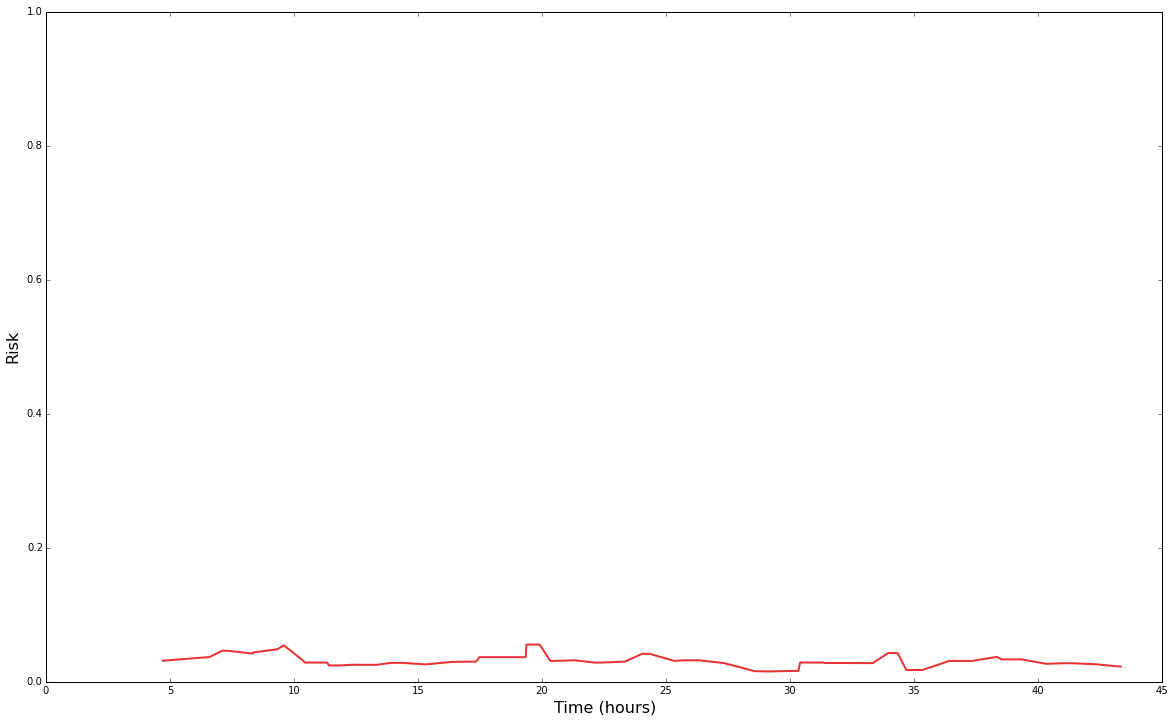

In [9]:
plt.figure(figsize=[20,12])
plt.plot(t,y_prob,'-',color=col[0],linewidth=2)

plt.xlabel('Time (hours)',fontsize=16)
plt.ylabel('Risk',fontsize=16)

ax = plt.gca()
ax.set_ylim([0,1])

# what changed to cause these large spikes?
idxBigJump = np.where((y_prob[1:] - y_prob[0:-1]) > 0.1)[0] + 1

ylim = plt.ylim()

for i, val in enumerate(idxBigJump):
    #print(i, val)
    X_big = X_curr[val,:]
    X_sml = X_curr[val-1,:]
    
    idxDiff = np.where(abs(X_big - X_sml) > 1e-4)[0]
    
    # now look for *big* differences
    
    # get anchors for plot locations
    anchor_x = t[val]
    anchor_y = ylim[1]-0.1*(ylim[1]-ylim[0]) # the higher prob
    
    for m, mval in enumerate(idxDiff):
        if X_big[mval] > X_sml[mval]:
            txt_for_plot = '^   ' + X_header[mval]
        else:
            txt_for_plot = ' v  ' + X_header[mval]
            
        plt.plot([anchor_x, anchor_x], [0.0,0.9], '--', color='k', linewidth=2)
        plt.text(anchor_x+1,anchor_y-(m*0.02),txt_for_plot,fontsize=14)
            
    
plt.show()

In [55]:
co.loc[[202887, 200806, 206719, 203461, 207012, 202887, 207046, 200806, 205803, 201975, 209108],'hospital_expire_flag']

icustay_id
202887    0
200806    0
206719    0
203461    0
207012    1
202887    0
207046    1
200806    0
205803    0
201975    0
209108    0
Name: hospital_expire_flag, dtype: int64

In [12]:
col

[[0.9047, 0.1918, 0.1988],
 [0.2941, 0.5447, 0.7494],
 [0.3718, 0.7176, 0.3612],
 [1.0, 0.5482, 0.1],
 [0.455, 0.4946, 0.4722],
 [0.6859, 0.4035, 0.2412],
 [0.9718, 0.5553, 0.7741],
 [0.5313, 0.3359, 0.6523]]

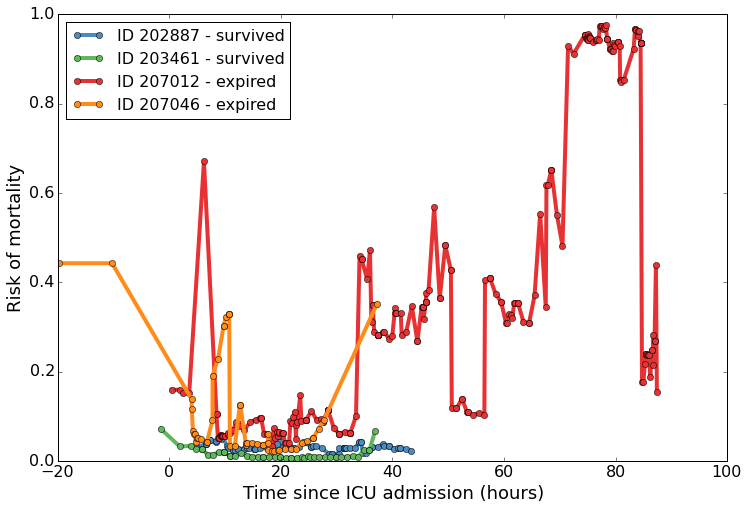

In [19]:
iids = [202887, 203461, 207012, 207046]

col_map = {202887: col[1],
          203461: col[2],
          207012: col[0],
          207046: col[3]}

plt.figure(figsize=[12,8])

for i, iid in enumerate(iids):
    # load in a single individual's data from saved csv files (for convenience)
    df_curr = pd.read_csv('./data/' + str(iid) + '.0.csv')
    df_curr.set_index('charttime_elapsed',inplace=True)

    # this can take ~10-30 seconds to generate the features for all the rows
    df_x = mp.extract_feature_across_sp(df_curr)
    X_curr = df_x.values.astype(float)

    # add in the static variables
    X_static = np.tile(df_static.loc[iid,vars_static].values, [X_curr.shape[0],1]).astype(float)
    X_curr = np.column_stack([X_curr, X_static])

    # create the outcome
    y_curr = co.loc[iid,'hospital_expire_flag']

    # generate probability for the window selected for this patient
    y_prob = xgb_model.predict_proba(X_curr)
    y_prob = y_prob[:,1]

    # plot this probability over time
    t = df_x.index.values/60.0/60.0 + 4.0 # convert to hours, add offset so t indexes the *end* time


    #df_x.head(n=20)
    if y_curr == 0:
        lbl = 'ID {} - survived'.format(iid)
    else:
        lbl = 'ID {} - expired'.format(iid)
        
    plt.plot(t,y_prob,'-',color=col_map[iid], linestyle='-', marker='o', linewidth=4, label=lbl)


plt.xlabel('Time since ICU admission (hours)',fontsize=18)
plt.ylabel('Risk of mortality',fontsize=18)
plt.legend(loc='upper left',fontsize=16)

ax = plt.gca()
ax.set_ylim([0,1])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

plt.savefig('example_risks.pdf')
plt.savefig('example_risks.png')
plt.show()

In [ ]:
inputs = mp.query_infusions(iid)
inputs['icustarttimehr'] = inputs['icustarttime'] / np.timedelta64(1,'h')
inputs['icuendtimehr'] = inputs['icuendtime'] / np.timedelta64(1,'h')

In [ ]:
codestatus = mp.query_codestatus(iid) # takes 2-3 minutes
if codestatus.shape[0]>0:
    codestatus['icutimehr'] = codestatus['icutime'] / np.timedelta64(1,'h')

In [ ]:
# Plot sample data over first 24 hours from admission to ICU
# Credit: Randal Olson for styling (http://www.randalolson.com/2014/06/28/)

# Prepare the size of the figure
fig = plt.figure(figsize=(22, 20))
plt.rcParams.update({'font.size': 22})

# "Tableau 20" colors as RGB.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
# Remove the plot frame lines. 
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
ax.axis([0,60,0,225])

# Plot risk
plt.plot(t,100.0*y_prob,'-',
         label='Risk of mortality (%)',
         color=col[0],linewidth=2)


# Plot input/output events
plt.plot(inputs.icustarttimehr[inputs.amountuom=='mL'], 
         inputs.amount[inputs.amountuom=='mL'].cumsum()/100, 
         color=tableau20[9], lw=2.5,
         marker='o', markersize=6, label='Intake volume, dL')

#plt.plot(outputs.icutimehr, 
#         outputs.value.cumsum()/100, 
#         color=tableau20[10], lw=2.5,
#         marker='o', markersize=6, label='Output volume, dL')

# Plot intravenous meds

iv_meds = [x for x in inputs.label.unique()
           if x != 'Gastric Meds'
           and x != 'PO Intake']

for m, med in enumerate(iv_meds):
    y_loc = 165-(m*5) # where on the y-axis the data is plotted
    unit = [x for x in inputs.loc[inputs['label']==med,'rateuom'].unique()
        if x != '']
    if len(unit)>0:
        unit = ', ' + str(unit[0])
    else:
        unit = ''
    
    plt.text(np.max(inputs.icuendtimehr)+0.5,y_loc,med + unit,fontsize=17)
    
    for i,row in inputs.loc[(inputs["label"] == med) & (inputs["rate"] > 0)].iterrows():
        plt.plot([row['icustarttimehr'],row['icuendtimehr']],[y_loc]*2,
                 color=tableau20[16], lw=4,marker='o', markersize=6)
        plt.text(row['icustarttimehr'], y_loc,
                 str(round(row['rate'],1)),
                 fontsize=15)
        
    if inputs.loc[(inputs["label"] == med) & (inputs["rate"] > 0)].shape[0] == 0:
        plt.plot(inputs.icustarttimehr[inputs.label==med],
                  [y_loc+1.5]*len(inputs[inputs.label==med]),
                  color=tableau20[16], lw=0, marker='o', markersize=6)
        # dashed line to guide the eye
        plt.plot([0,np.max(inputs.icuendtimehr)],
                  [y_loc+1.5]*2,
                  color=[0.3,0.3,0.3], lw=2, linestyle=':', markersize=6)

# Plot code status
if codestatus.shape[0]>0:
    plt.text(-10,220,'Code status',fontsize=17) 
    for i, txt in enumerate(codestatus.value[codestatus.label=='Code Status'].values):
            plt.annotate(txt, (codestatus.icutimehr[codestatus.label=='Code Status'].
                               values[i],220),fontsize=17)
        
plt.legend(loc=5,fontsize=18)
plt.xlabel('Time after admission to the intensive care unit, hours', fontsize=22)
plt.ylabel('Measurement, absolute value', fontsize=22)
plt.yticks(np.arange(0, 140, 20))

plt.show()

In [ ]:
def plt_and_save(iid, plotText=True):
    # load in a single individual's data from saved csv files (for convenience)
    df_curr = pd.read_csv('./data/' + str(iid) + '.csv')
    df_curr['charttime'] = pd.to_datetime(df_curr['charttime'])

    # change charttime into time elapsed
    df_curr['timeelapsed'] = (df_curr['charttime'] - df_static.loc[iid,'intime']) / np.timedelta64(1, 'm')
    df_curr.set_index('timeelapsed',inplace=True)
    df_curr.head()

    # this can take ~10-30 seconds to generate the features for all the rows
    df_x = mp.extract_feature_across_sp(df_curr)
    X_curr = df_x.values.astype(float)

    # add in the static variables
    X_static = np.tile(df_static.loc[iid,vars_static].values, [X_curr.shape[0],1]).astype(float)
    X_curr = np.column_stack([X_curr, X_static])

    if iid not in co.index:
        return
    
    # create the outcome
    y_curr = np.tile( co.loc[iid,'hospital_expire_flag'], [X_curr.shape[0],] )

    # generate probability for the window selected for this patient
    y_prob = xgb_model.predict_proba(X_curr)
    y_prob = y_prob[:,1]

    # plot this probability over time
    t = df_x.index.values/60.0 + 4.0 # convert to hours, add offset so t indexes the *end* time
    
    fig = plt.figure(figsize=[12,9])
    plt.plot(t,y_prob,'-',color=col[0],linewidth=2)
    
    # plot time of death
    if str(df_static.loc[iid_curr,'deathtime']) != 'NaT':
        tod = (df_static.loc[iid,'deathtime'] - df_static.loc[iid, 'intime']) / np.timedelta64(1, 'h')
        plt.plot([tod,tod], [0,1], linestyle='--', lw=3, color=col[4])
        hosp_exp = '1'
    else:
        hosp_exp = '0'
        
    plt.xlabel('Time (hours)',fontsize=16)
    plt.ylabel('Risk',fontsize=16)

    ax = plt.gca()
    ax.set_ylim([0,1])
    
    if plotText == True:
        # what changed to cause these large spikes?
        idxBigJump = np.where((y_prob[1:] - y_prob[0:-1]) > 0.1)[0] + 1

        ylim = plt.ylim()

        for i, val in enumerate(idxBigJump):
            #print(i, val)
            X_big = X_curr[val,:]
            X_sml = X_curr[val-1,:]

            idxDiff = np.where(abs(X_big - X_sml) > 1e-4)[0]

            # now look for *big* differences

            # get anchors for plot locations
            anchor_x = t[val]
            anchor_y = ylim[1]-0.1*(ylim[1]-ylim[0]) # the higher prob

            currVal = 0
            for m, mval in enumerate(idxDiff):
                if X_big[mval] > X_sml[mval]:
                    txt_for_plot = '^   ' + X_header[mval]
                else:
                    txt_for_plot = ' v  ' + X_header[mval]

                # the if statement tries to throttle overlapping labels
                if mval > (currVal+4):
                    plt.plot([anchor_x, anchor_x], [0.0,0.9], '--', color='k', linewidth=2)
                    plt.text(anchor_x+1,anchor_y-(m*0.02),txt_for_plot,fontsize=14)
                    currVal = mval
    
    plt.title(str(iid) + ', hospital expiry = ' + hosp_exp,fontsize=14)
    fig.set_size_inches(10, 6)
    fig.savefig('./plots/' + str(iid) + '.pdf', dpi=300, bbox_inches='tight')

In [ ]:
#pd.DataFrame(X_curr,columns=X_header).to_csv('tmpdata.csv')

In [ ]:
# write a function that, given two times, calculates:
#  - the top 3 features which resulted in a lower risk
#  - the top 3 features which resulted in a higher risk

# what changed to cause these large spikes?
idxBigJump = np.where((y_prob[1:] - y_prob[0:-1]) > 0.1)[0] + 1

t1 = idxBigJump[0]-1
t2 = idxBigJump[0]

# bonus points for some estimate of the increased risk
def features_changing_risk(X, mdl, t1=0, t2=1):
    X1 = np.reshape(X[t1,:],[1,X.shape[1]])
    X2 = np.reshape(X[t2,:],[1,X.shape[1]])
    
    #print(X1)
    #print(X2)
    y1 = mdl.predict_proba(X1)[0,1]
    y2 = mdl.predict_proba(X2)[0,1]
    print('Pred1: {:0.4f}. Pred2: {:0.4f}.'.format(y1,y2))
    
    # look for any difference
    idxDiff = np.where(abs(X2 - X1) > 1e-4)[1]
    
    # now loop through and look for *big* differences
    diffMagnitude = np.zeros(idxDiff.shape)
    for m, mval in enumerate(idxDiff):
        X_tmp = np.copy(X1)
        X_tmp[0,mval] = X2[0,mval]
        
        y_eval = mdl.predict_proba(X_tmp)
        y_eval = y_eval[0,1]
        
        y_diff = y_eval-y1
        y_diff_pct = (y_eval-y1) / abs(y2-y1) * 100.0
        
        diffMagnitude[m] = y_diff_pct
        print('{:3g} of {:3g} - idx={:3g}'.format(m, len(idxDiff), mval),
              '{:20s} - {:0.4f} vs. {:0.4f}'.format(X_header[mval], y_eval, y1),
              '\t{:1.4f}, {:2.1f}% of the overall change'.format(y_diff, y_diff_pct))
        
    
    sort_indices = np.argsort(diffMagnitude)
    idxDiff = idxDiff[sort_indices]
    if len(idxDiff)<3:
        idxDiff = [idxDiff, np.nan, np.nan]
    
    return idxDiff[0:3]

idxIncreased = features_changing_risk(X_curr, xgb_model, t1=t1, t2=t2)

In [ ]:
# write a function that, given two times, calculates:
#  - the top 3 features which resulted in a lower risk
#  - the top 3 features which resulted in a higher risk

# what changed to cause these large spikes?
idxBigJump = np.where((y_prob[1:] - y_prob[0:-1]) > 0.1)[0] + 1

t1 = idxBigJump[0]-1
t2 = idxBigJump[0]

# bonus points for some estimate of the increased risk
def feature_importance(X, mdl, t1=0, t2=1):
    X1 = np.reshape(X[t1,:],[1,X.shape[1]])
    X2 = np.reshape(X[t2,:],[1,X.shape[1]])
    
    #print(X1)
    #print(X2)
    y1 = mdl.predict_proba(X1)[0,1]
    y2 = mdl.predict_proba(X2)[0,1]
    print('Pred1: {:0.4f}. Pred2: {:0.4f}.'.format(y1,y2))
    
    # look for any difference
    idxDiff = np.where(abs(X2 - X1) > 1e-4)[1]
    
    # now loop through and look for *big* differences
    diffMagnitude = np.zeros(idxDiff.shape)
    for m, mval in enumerate(idxDiff):
        X_tmp = np.copy(X2)
        X_tmp[0,mval] = X1[0,mval]
        
        y_eval = mdl.predict_proba(X_tmp)
        y_eval = y_eval[0,1]
        
        y_diff = y_eval-y1
        y_diff_pct = (y2-y_eval) / abs(y2-y1) * 100.0
        
        diffMagnitude[m] = y_diff_pct
        print('{:3g} of {:3g} - idx={:3g}'.format(m, len(idxDiff), mval),
              '{:20s} - {:0.4f} vs. {:0.4f}'.format(X_header[mval], y_eval, y1),
              '\t{:1.4f}, {:2.1f}% of the overall change'.format(y_diff, y_diff_pct))
        
    
    sort_indices = np.argsort(diffMagnitude)
    idxDiff = idxDiff[sort_indices]
    if len(idxDiff)<3:
        idxDiff = [idxDiff, np.nan, np.nan]
    
    return idxDiff[0:3]

idxIncreased = feature_importance(X_curr, xgb_model, t1=t1, t2=t2)

In [ ]:
# problem with the above is it's all univariate.. so if we remove/add a single feature, it's not really representative of the change

In [ ]:
# load in a single individual's data from saved csv files (for convenience)
iid = 207012 # 203461, 207012
df_curr = pd.read_csv('./data/' + str(iid) + '.csv')
df_curr['charttime'] = pd.to_datetime(df_curr['charttime'])

# change charttime into time elapsed
df_curr['timeelapsed'] = (df_curr['charttime'] - df_static.loc[iid,'intime']) / np.timedelta64(1, 'm')
df_curr.set_index('timeelapsed',inplace=True)
df_curr.head()

# this can take ~10-30 seconds to generate the features for all the rows
df_x = mp.extract_feature_across_sp(df_curr)
X_curr = df_x.values.astype(float)

# add in the static variables
X_static = np.tile(df_static.loc[iid,vars_static].values, [X_curr.shape[0],1]).astype(float)
X_curr = np.column_stack([X_curr, X_static])

# create the outcome
y_curr = np.tile( co.loc[iid,'hospital_expire_flag'], [X_curr.shape[0],] )

# generate probability for the window selected for this patient
y_prob = xgb_model.predict_proba(X_curr)
y_prob = y_prob[:,1]

In [ ]:
# plot this probability over time
t = df_x.index.values # convert to hours

plt.figure(figsize=[9,9])
plt.plot(t,y_prob,'-',color=col[0],linewidth=2)

plt.xlabel('Time (hours)',fontsize=16)
plt.ylabel('Risk',fontsize=16)
plt.show()

In [ ]:
df_x.iloc[145:165].T

In [ ]:
# this prints out three random test cases which we have .csv files for
# we only saved csv files for ICUSTAY_ID < 210000, to save space
iid_test[iid_test < 210000][40:80]
# 202887, 207046, 200806, 205803, 201975, 209108 are metavision patients